## Character LSTM Generative Model

### Imports

In [1]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from urllib import urlopen
from IPython.display import HTML as html_print
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
%matplotlib inline

Using TensorFlow backend.


### Constants

In [2]:
DATA_DIR = "../../data"

INPUT_URL = "http://www.gutenberg.org/files/11/11-0.txt"
INPUT_TEXT = os.path.join(DATA_DIR, "alice.txt")

BEST_MODEL_PATH = os.path.join(DATA_DIR, "05-char-lstm-gen-best.h5")
FINAL_MODEL_PATH = os.path.join(DATA_DIR, "05-char-lstm-gen-final.h5")

TRAIN_SEQLEN = 40
PREDICT_SEQLEN = 100

NUM_EPOCHS = 60
BATCH_SIZE = 128

### Download Data

Our data comes from the text of the children's novel [Alice in Wonderland](https://en.wikipedia.org/wiki/Alice%27s_Adventures_in_Wonderland) by Lewis Carroll, hosted on [Project Gutenberg](http://www.gutenberg.org/). In an effort to make the notebook self-sufficient, we download the file from the  project site if it is not already available in our data directory.

In [3]:
def maybe_download(url, file):
    if os.path.exists(file):
        return
    fin = urlopen(url)
    fout = open(file, "wb")
    fout.write(fin.read())
    fout.close()
    fin.close()


maybe_download(INPUT_URL, INPUT_TEXT)
text = open(INPUT_TEXT).read().decode("ascii", "ignore").lower()
# text = open(INPUT_TEXT).read().lower()

### Setup Vocabulary and Lookup Tables

In [4]:
chars = sorted(list(set([c for c in text])))
vocab_size = len(chars)
print("vocab_size:", vocab_size)

vocab_size: 57


In [5]:
char2idx = dict([(c, i) for i, c in enumerate(chars)])
idx2char = dict([(i, c) for i, c in enumerate(chars)])

### Chunk and Vectorize

In [6]:
xdata, ydata = [], []
for i in range(0, len(text) - TRAIN_SEQLEN):
    xdata.append(text[i : i + TRAIN_SEQLEN])
    ydata.append(text[i + TRAIN_SEQLEN])

assert(len(xdata) == len(ydata))
print("# sequences:", len(xdata))
for i in range(10):
    print("{:d}: {:s}\t{:s}".format(i, xdata[i], ydata[i]))

# sequences: 164492
0: project gutenbergs alices adventures in 	w
1: roject gutenbergs alices adventures in w	o
2: oject gutenbergs alices adventures in wo	n
3: ject gutenbergs alices adventures in won	d
4: ect gutenbergs alices adventures in wond	e
5: ct gutenbergs alices adventures in wonde	r
6: t gutenbergs alices adventures in wonder	l
7:  gutenbergs alices adventures in wonderl	a
8: gutenbergs alices adventures in wonderla	n
9: utenbergs alices adventures in wonderlan	d


In [7]:
def vectorize(vocab_size, char2idx, xdata, ydata=None):
    X = np.zeros((len(xdata), TRAIN_SEQLEN, vocab_size), dtype=np.bool)
    Y = None if ydata is None else np.zeros((len(xdata), vocab_size), dtype=np.bool) 
    for i, x in enumerate(xdata):
        for j, c in enumerate(x):
            X[i, j, char2idx[c]] = 1
        if ydata is not None:
            Y[i, char2idx[ydata[i]]] = 1
    return X, Y


X, Y = vectorize(vocab_size, char2idx, xdata, ydata)
print(X.shape, Y.shape)

(164492, 40, 57) (164492, 57)


### Build and train model

This step takes a while the first time. The model itself is quite simple and is adapted from the [Keras example of character LSTM based generative model](https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py) that is given 40 characters of text and asked to predict the next character. Network architecture and optimizer settings are identical to that in the example. It takes a while to train, so we will only train it the first time, the next time the model is just loaded from the best saved model during training.

In [8]:
history = None
if not os.path.exists(BEST_MODEL_PATH):
    # build model
    model = Sequential()
    model.add(LSTM(128, input_shape=(TRAIN_SEQLEN, vocab_size)))
    model.add(Dense(vocab_size))
    model.add(Activation("softmax"))
    # compile model
    optim = RMSprop(lr=1e-2)
    model.compile(loss="categorical_crossentropy", optimizer=optim)
    # train model
    checkpoint = ModelCheckpoint(filepath=BEST_MODEL_PATH, save_best_only=True)
    history = model.fit(X, Y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        validation_split=0.1, callbacks=[checkpoint])
    final_model = model.save(FINAL_MODEL_PATH)

Train on 148042 samples, validate on 16450 samples
Epoch 1/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.8959 - val_loss: 2.2568
Epoch 2/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.5029 - val_loss: 2.1349
Epoch 3/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.3966 - val_loss: 2.1081
Epoch 4/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.3405 - val_loss: 2.1214
Epoch 5/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.3068 - val_loss: 2.1032
Epoch 6/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.2792 - val_loss: 2.1987
Epoch 7/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.2601 - val_loss: 2.1281
Epoch 8/60
148042/148042 [==============================] - 155s 1ms/step - loss: 1.2439 - val_loss: 2.1206
Epoch 9/60
148042/148042 [==============================] - 156s 1ms/step - loss: 1.2

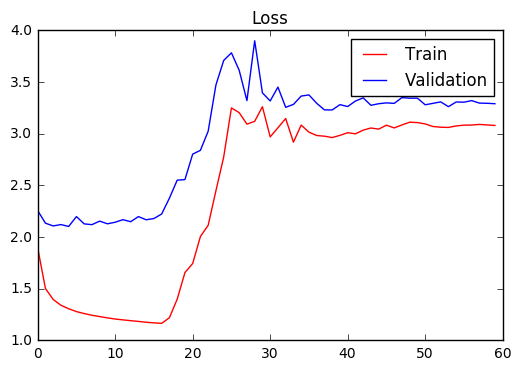

In [9]:
if history is not None:
    plt.title("Loss")
    plt.plot(history.history["loss"], color="r", label="Train")
    plt.plot(history.history["val_loss"], color="b", label="Validation")
    plt.legend(loc="best")
    plt.show()

### Predict

We want to compare greedy search, ie, selecting the best predicted character at each step with beam search, that considers the top k predictions at each step and predicts the best resulting sequence. We will take a set of random 40 character sequences from the text and generate results of greedy search vs beam search for each of them.

From Jason Brownlee's tutorial on [How to Implement a Beam Search Decoder for Natural Language Processing](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/):

> Instead of greedily choosing the most likely next step as the sequence is constructed, the beam search expands all possible next steps and keeps the k most likely, where k is a user-specified parameter and controls the number of beams or parallel searches through the sequence of probabilities.

> We do not need to start with random states; instead, we start with the k most likely words as the first step in the sequence.

Note that greedy search is just a degenerate case of beam search where the beam size k=1.

In [10]:
model = load_model(BEST_MODEL_PATH)

In [11]:
def predict_using_beam_search(model, seed_text, predict_seqlen, vocab_size, 
                              char2idx, idx2char, k):
    inputs = [(seed_text, 0.0, "")]
    for ppos in range(predict_seqlen):
        outputs = []
        # predict for each input tuple
        for input_text, log_prob, pred_chars in inputs:
            Xpred, _ = vectorize(vocab_size, char2idx, [input_text])
            Ypred = model.predict(Xpred)[0]
            top_idxs = np.argsort(Ypred)[-k:]
            for top_idx in top_idxs:
                pred_char = idx2char[top_idx]
                new_input_text = input_text[1:] + pred_char
                new_log_prob = log_prob + np.log(Ypred[top_idx])
                new_pred_chars = pred_chars + pred_char
                outputs.append((new_input_text, new_log_prob, new_pred_chars))
        if len(outputs) > k:
            top_outputs = sorted(outputs, key=operator.itemgetter(1),
                                reverse=True)[0:k]
            inputs = top_outputs
        else:
            inputs = outputs
    predicted_seq = sorted(inputs, key=operator.itemgetter(1), reverse=True)[0][2]
    return predicted_seq


def cstr(s, color="black"):
    return "<text style=color:{:s}>{:s}</text>".format(color, s)


html_output = ""
for tid in range(10):
    start_idx = np.random.randint(len(text) - TRAIN_SEQLEN)
    seed_text = text[start_idx : start_idx + TRAIN_SEQLEN]
    html_output += "<p>Example {:d}<br/>".format(tid + 1)
    for beam_size in [1, 3, 5, 7]:
        predicted_seq = predict_using_beam_search(model, seed_text, PREDICT_SEQLEN,
                                                  vocab_size, char2idx, idx2char, 
                                                  beam_size)
        html_output += "---- beam size {:d}: {:s}<br/>\n".format(
            beam_size, "".join([cstr(seed_text, color="red"), predicted_seq]))
    html_output += "</p>"
html_print(cstr(html_output))